In [1]:
import flexynesis 
import torch, os
torch.set_num_threads(12)

In [2]:
if not os.path.exists("neuroblastoma"):
    !wget -O neuroblastoma.tgz "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/neuroblastoma.tgz" && tar -xzvf neuroblastoma.tgz

In [3]:
data_importer = flexynesis.DataImporter(path ='./neuroblastoma/', 
                                       data_types = ['gex'], 
                                        min_features=1000, top_percentile=100)
train_dataset, test_dataset = data_importer.import_data()


[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data -----------------
[INFO] Importing ./neuroblastoma/train/clin.csv...
[INFO] Importing ./neuroblastoma/train/gex.csv...

[INFO] ----------------- Reading Data -----------------
[INFO] Importing ./neuroblastoma/test/clin.csv...
[INFO] Importing ./neuroblastoma/test/gex.csv...

[INFO] ---------- Processing Data (train) ----------

[INFO] --------------- Cleaning Up Data ---------------
Imputing NA values to median of features, affected # of features  31079  # of rows: 16557


100%|██████████| 16557/16557 [00:03<00:00, 5016.97it/s]


Number of NA values:  0
[INFO] DataFrame gex - Removed 474 features.
DataFrame gex - Removed 0 samples (0.00%).
Implementing feature selection using laplacian score for layer: gex with  16961 features
Returning original matrix, demanded # of features is  larger than existing number of features

[INFO] ---------- Processing Data (test) ----------

[INFO] --------------- Cleaning Up Data ---------------
Imputing NA values to median of features, affected # of features  19  # of rows: 13


100%|██████████| 13/13 [00:00<00:00, 2973.22it/s]


Number of NA values:  0
[INFO] DataFrame gex - Removed 676 features.
DataFrame gex - Removed 0 samples (0.00%).

[INFO] ------------ Harmonizing Data Sets ------------

[INFO] --------------- Normalizing Data ---------------

[INFO] --------------- Normalizing Data ---------------
[INFO] Data import successful.


In [4]:
flexynesis.print_summary_stats(train_dataset)

Summary for variable: disease
Categorical Variable Summary:
  Label: Neuroblastoma, Count: 139
------
Summary for variable: mycn
Categorical Variable Summary:
  Label: MYCN_amp, Count: 37
  Label: other, Count: 102
------
Summary for variable: subtype
Categorical Variable Summary:
  Label: High, Count: 23
  Label: Intermediate, Count: 29
  Label: Low, Count: 36
  Label: Unknown, Count: 28
  Label: nan, Count: 23
------
Summary for variable: dataset
Categorical Variable Summary:
  Label: DEPMAP, Count: 23
  Label: TARGET, Count: 116
------


In [50]:
tuner = flexynesis.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.supervised_vae, 
                                        target_variables = "mycn",
                                        batch_variables="dataset",
                                        config_name = "supervised_vae", 
                                        config_path = './conf.yaml',
                                        n_iter=20, plot_losses=True, early_stop_patience=20)

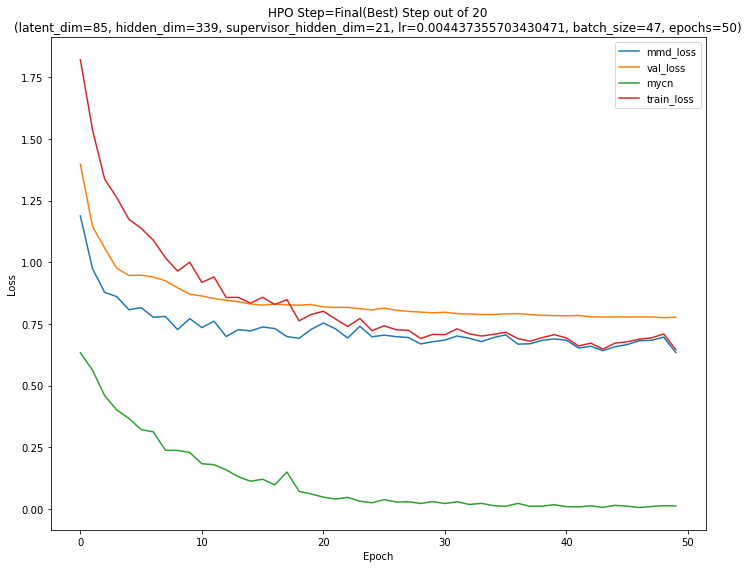

`Trainer.fit` stopped: `max_epochs=50` reached.


{'latent_dim': 85,
 'hidden_dim': 339,
 'supervisor_hidden_dim': 21,
 'lr': 0.004437355703430471,
 'batch_size': 47,
 'epochs': 50}

In [51]:
model, best_params = tuner.perform_tuning()
best_params

In [52]:
y_pred_dict = model.predict(test_dataset)

In [53]:
metrics_df = flexynesis.evaluate_wrapper(y_pred_dict, test_dataset)
metrics_df

Balanced Accuracy: 0.7765
F1 Score (Macro): 0.7900
Cohen's Kappa: 0.5817

Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.64      0.70        11
         1.0       0.85      0.92      0.88        24

    accuracy                           0.83        35
   macro avg       0.81      0.78      0.79        35
weighted avg       0.82      0.83      0.82        35



,var,variable_type,metric,value
0,mycn,categorical,balanced_acc,0.776515
1,mycn,categorical,f1_score,0.790000
2,mycn,categorical,kappa,0.581673


In [54]:
ds = train_dataset
E = model.transform(ds)

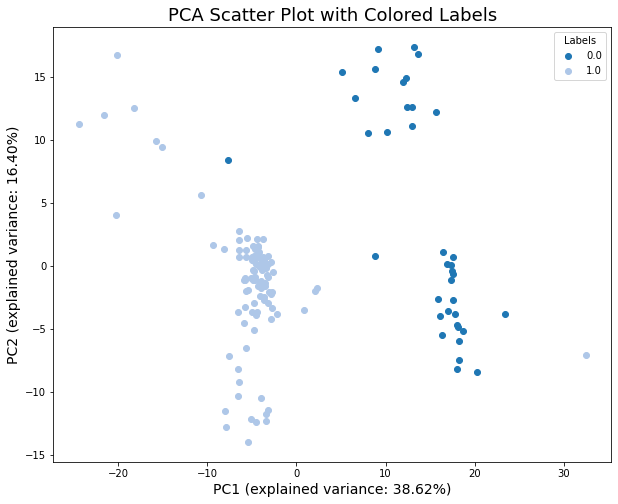

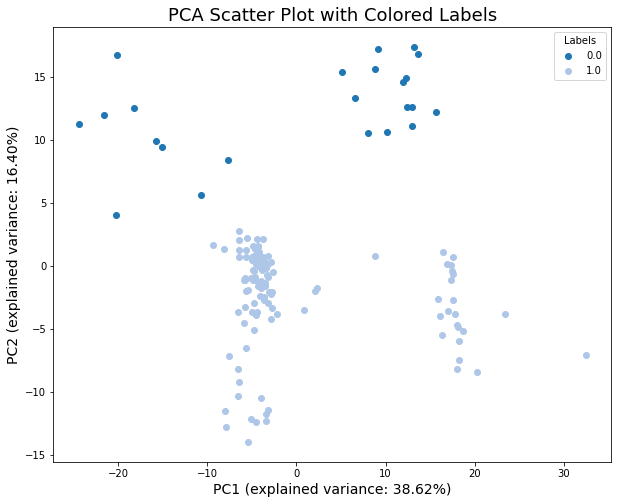

(None, None)

In [55]:
flexynesis.plot_dim_reduced(E, labels = ds.ann['mycn'].numpy()), flexynesis.plot_dim_reduced(E, labels = ds.ann['dataset'].numpy())

In [76]:
E2 = flexynesis.remove_batch_associated_variables(data = E, variable_types=ds.variable_types, 
                                                  target_dict = {x: train_dataset.ann[x] for x in model.target_variables},
                                                  batch_dict= {x:train_dataset.ann[x] for x in model.batch_variables}, mi_threshold=0.1)

In [77]:
E.shape, E2.shape

((139, 85), (139, 3))

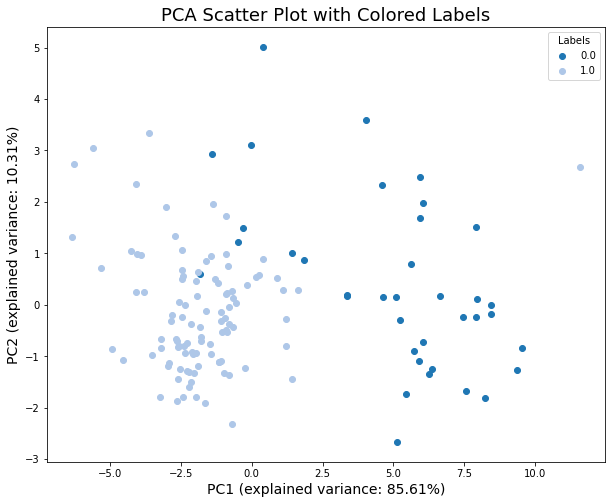

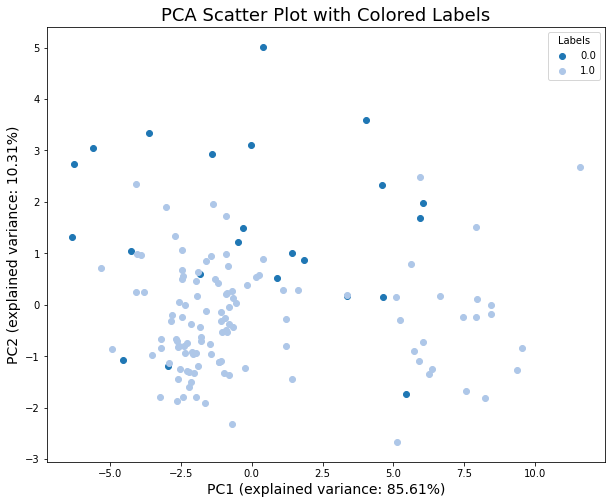

(None, None)

In [78]:
flexynesis.plot_dim_reduced(E2, labels = ds.ann['mycn'].numpy()), flexynesis.plot_dim_reduced(E2, labels = ds.ann['dataset'].numpy())